## 💡 영감

- **목적**: Deep Convolutional Generative Adversarial Network (**DCGAN**)을 사용하여 새로운 애니메이션 캐릭터의 얼굴을 생성합니다.

- 이 노트북은 Deep Convolutional Generative Adversarial Network (**DCGAN**)을 사용하여 애니메이션 캐릭터의 이미지를 생성하는 방법을 보여줍니다.


생성적 적대 신경망(GANs)은 오늘날 컴퓨터 과학에서 가장 흥미로운 아이디어 중 하나입니다.

두 모델은 적대적 과정을 통해 동시에 훈련됩니다. 생성기("예술가")는 실제처럼 보이는 이미지를 만드는 법을 배우고, 판별기("예술 비평가")는 진짜 이미지와 가짜를 구별하는 법을 배웁니다.


## Deep Convolutional GAN (DCGAN)

**DCGAN**은 가장 인기 있고 성공적인 GAN 구현 중 하나입니다. 이것은 다층 퍼셉트론 대신 ConvNets로 구성되어 있습니다. ConvNets는 최대 풀링 없이 구현되며, 실제로는 컨볼루셔널 스트라이드로 대체됩니다. 또한, 레이어들은 완전히 연결되어 있지 않습니다.


### 라이브러리 임포트


In [ ]:
# CV 오류시 설치
# !pip install opencv-python -q

In [5]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터셋 로딩 및 전처리


변수 `DATA_DIR`은 Anime Faces 데이터셋이 위치한 디렉토리 경로를 저장합니다.

이 경로는 데이터를 로드할 때 사용됩니다.


In [6]:
DATA_DIR = "anime-faces"  # 데이터 디렉토리 경로를 지정합니다.

변수 `image_size`는 이미지의 크기를 정의하며, `batch_size`는 한 번에 처리할 이미지의 수를 지정합니다. `stats`는 이미지 데이터를 정규화할 때 사용되는 평균과 표준편차를 튜플 형태로 저장합니다. 이는 모델 학습에 있어 데이터 전처리 단계에서 중요한 역할을 합니다.


In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

`ImageFolder`를 사용하여 데이터셋을 로드하고, `tt.Compose`를 통해 여러 변환(transformations)을 순차적으로 적용합니다. 이 과정에는 이미지 크기 조정(`tt.Resize`), 중앙 자르기(`tt.CenterCrop`), 텐서로 변환(`tt.ToTensor`), 그리고 정규화(`tt.Normalize`)가 포함됩니다. 여기서 `DATA_DIR`은 이미지 데이터셋이 위치한 디렉토리, `image_size`는 이미지의 크기, `stats`는 정규화를 위한 평균과 표준편차를 나타냅니다.


In [8]:
train_ds = ImageFolder(
    DATA_DIR,
    transform=tt.Compose(
        [
            tt.Resize(image_size),
            tt.CenterCrop(image_size),
            tt.ToTensor(),
            tt.Normalize(*stats),
        ]
    ),
)

- 애니메이션 얼굴 이미지는 다양한 크기로 되어 있습니다. 먼저, 이들을 64 x 64의 고정된 크기로 조정하세요.

- 그 다음, 평균과 표준편차가 0.5인 정규화를 사용하세요. 평균과 분산이 세 개의 값으로 구성되어 있다는 점을 유의하세요. 왜냐하면 여러분이 다루고 있는 것은 RGB 이미지이기 때문입니다.

- 정규화는 픽셀 값을 [0, 255] 범위에서 [-1, 1] 범위로 매핑합니다. 픽셀 값을 [-1, 1] 사이로 매핑하는 것은 GANs를 훈련시키는 동안 유용하다고 입증되었습니다.
- 또한, 이미지를 torch 텐서로 변환하세요.


이 함수는 `DataLoader`를 사용하여 데이터셋을 배치로 나누고, 데이터를 섞는 동시에 멀티프로세싱을 통해 데이터 로딩 속도를 향상시킵니다. `train_ds`는 로드할 데이터셋, `batch_size`는 한 번에 로드할 데이터의 양, `shuffle`은 데이터를 섞을지 여부, `num_workers`는 데이터 로딩에 사용할 프로세스 수, `pin_memory`는 데이터를 GPU의 메모리에 고정시킬지 여부를 지정합니다.


In [9]:
# DataLoader를 사용하여 train_ds 데이터셋을 배치 크기로 나누고, 데이터를 섞으며, 2개의 작업자를 사용하여 메모리에 고정시킵니다.
train_dl = DataLoader(
    train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True
)

이 함수는 이미지 텐서를 입력으로 받아 정규화를 해제하는 작업을 수행합니다. 정규화 해제는 입력된 텐서에 `stats`의 두 번째 요소의 첫 번째 값(`stats[1][0]`)을 곱하고, `stats`의 첫 번째 요소의 첫 번째 값(`stats[0][0]`)을 더하는 방식으로 이루어집니다. 여기서 `stats`는 정규화에 사용된 평균과 표준편차를 담고 있는 변수로 가정합니다.


In [10]:
def denorm(img_tensors):
    # 이미지 텐서를 정규화 해제합니다.
    return img_tensors * stats[1][0] + stats[0][0]

이 함수들은 이미지 배치를 시각화하기 위해 사용됩니다. `show_images` 함수는 주어진 이미지들을 그리드 형태로 표시하며, 최대 `nmax` 개의 이미지를 표시합니다. 이 함수는 `plt.subplots`를 사용하여 그림과 축을 생성하고, 축의 눈금을 제거한 후, `make_grid` 함수를 통해 생성된 그리드 이미지를 표시합니다. `show_batch` 함수는 데이터 로더(`dl`)에서 배치를 하나 가져와 `show_images` 함수를 사용하여 이미지들을 표시합니다. 이 과정은 첫 번째 배치에 대해서만 수행됩니다.


In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

함수 `show_batch`는 데이터로더 `train_dl`에서 하나의 배치를 가져와 시각화합니다. 이 함수는 주로 데이터가 올바르게 로드되었는지 확인하고, 데이터의 형태와 내용을 빠르게 검토하기 위해 사용됩니다.


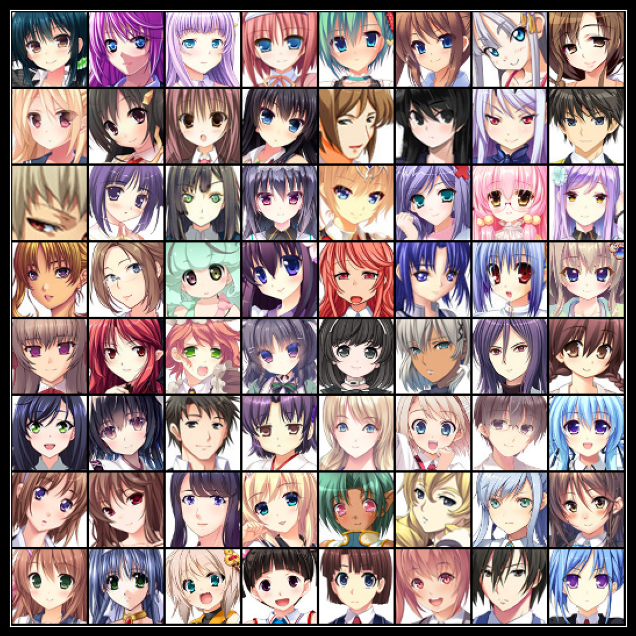

In [12]:
show_batch(train_dl)  # train_dl 데이터로더에서 배치를 시각화합니다.

이 함수와 클래스는 텐서 데이터를 특정 장치로 이동하는 기능을 제공합니다. `to_device` 함수는 단일 텐서 또는 텐서의 리스트/튜플을 입력으로 받아, 이를 지정된 장치로 비동기적으로 이동시킵니다. `DeviceDataLoader` 클래스는 데이터 로더를 감싸서, 데이터 로더가 생성하는 각 배치를 자동으로 지정된 장치로 이동시키는 역할을 합니다. 이를 통해, 데이터 로딩 과정에서의 장치 이동을 투명하게 처리할 수 있으며, GPU와 같은 특정 계산 장치에서의 데이터 처리를 용이하게 합니다.


In [13]:
def to_device(data, device):
    """텐서(들)을 선택한 장치로 이동"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """데이터로더를 감싸서 데이터를 장치로 이동"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """장치로 데이터를 이동한 후 데이터 배치를 생성"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """배치의 수"""
        return len(self.dl)

PyTorch를 사용하여 디바이스를 설정하는 방법을 보여줍니다. `torch.cuda.is_available()` 함수를 사용하여 CUDA가 사용 가능한지 확인하고, 사용 가능하면 `torch.device('cuda')`를 통해 CUDA 디바이스를 선택합니다. CUDA가 사용 불가능한 경우, `torch.device('cpu')`를 사용하여 CPU를 선택합니다. 이 방식은 PyTorch 모델을 학습시킬 때 최적의 디바이스를 자동으로 선택하는 데 유용합니다.


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# PyTorch에서 사용할 디바이스를 설정합니다. CUDA가 사용 가능하면 CUDA 디바이스를, 그렇지 않으면 CPU를 사용합니다.

device(type='cpu')

In [14]:
# MacOS 에서 GPU 대신 MPS 를 사용합니다.
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# device

device(type='mps')

`DeviceDataLoader` 클래스는 데이터 로더를 특정 디바이스(CPU 또는 GPU)에 맞게 감싸주어, 데이터를 해당 디바이스로 더 효율적으로 로드할 수 있게 해줍니다. 이는 특히 대규모 데이터셋을 다루는 머신러닝 및 딥러닝 작업에서 학습 시간을 단축시키는 데 유용합니다. 본 코드는 기존의 데이터 로더 `train_dl`을 받아, 지정된 `device`에 최적화된 `DeviceDataLoader` 인스턴스로 변환합니다.


In [15]:
# train_dl을 device에 맞게 DeviceDataLoader로 감싸줍니다.
train_dl = DeviceDataLoader(train_dl, device)

### 차별자 네트워크

단계별로 생각해 봅시다.


이 코드는 이미지를 분류하기 위한 디스크리미네이터 모델을 정의합니다. `nn.Sequential`을 사용하여 여러 계층을 순차적으로 쌓아 구성합니다. 모델은 3채널의 64x64 이미지를 입력받아, 여러 `nn.Conv2d` 계층을 거치며 특징을 추출합니다. 각 `nn.Conv2d` 계층 후에는 `nn.BatchNorm2d`와 `nn.LeakyReLU`를 적용하여 정규화와 비선형 활성화를 수행합니다. 최종적으로, 이미지가 진짜인지 가짜인지를 판별하는 1x1x1 크기의 출력을 생성합니다. 이 출력은 `nn.Flatten`을 거쳐 1차원으로 평탄화되고, `nn.Sigmoid`를 통해 0과 1 사이의 확률값으로 변환됩니다.


In [16]:
discriminator = nn.Sequential(
    # 입력: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # 출력: 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # 출력: 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # 출력: 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # 출력: 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # 출력: 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid(),
)

이 함수는 `discriminator` 객체를 지정된 `device`로 이동시키는 역할을 합니다. 이는 모델을 CPU나 GPU와 같은 특정 디바이스에 할당할 때 사용됩니다. 이 과정은 특히 딥러닝에서 모델의 학습이나 추론을 디바이스의 연산 능력에 맞추어 최적화하기 위해 필수적입니다.


In [17]:
# discriminator 객체를 device로 이동시킵니다.
discriminator = to_device(discriminator, device)

변수 `latent_size`는 잠재 공간의 차원을 정의하며, 여기서는 128로 설정되어 있다. 이는 인공지능 모델, 특히 생성적 적대 신경망(GANs)과 같은 모델에서 중요한 역할을 하는 파라미터로, 모델이 학습하는 동안 데이터의 내재된 특성을 표현하는 데 사용된다.


In [18]:
# latent_size 변수는 잠재 공간의 차원을 정의합니다.
latent_size = 128

### 발전기 네트워크


이 코드는 생성적 적대 신경망(GAN)의 생성기(generator) 구성을 정의합니다. 생성기는 잠재 공간(latent space)의 벡터를 입력으로 받아, 이를 실제 데이터와 유사한 데이터로 변환하는 역할을 합니다. 여기서는 `nn.Sequential`을 사용하여 여러 계층을 순차적으로 쌓아 올립니다. 각 계층은 `nn.ConvTranspose2d`를 사용하여 업샘플링을 수행하고, `nn.BatchNorm2d`로 배치 정규화를 적용한 후, `nn.ReLU`를 통해 비선형 활성화 함수를 적용합니다. 마지막 계층에서는 `nn.Tanh`를 사용하여 출력 데이터를 -1과 1 사이의 값으로 정규화합니다. 이 구조를 통해, 잠재 공간의 벡터는 최종적으로 3채널의 64x64 이미지로 변환됩니다.


In [19]:
generator = nn.Sequential(
    # 잠재 공간 크기에서 시작
    nn.ConvTranspose2d(
        latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False
    ),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # 출력: 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # 출력: 256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # 출력: 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # 출력: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh(),
    # 출력: 3 x 64 x 64
)

이 코드는 PyTorch를 사용하여 가짜 이미지를 생성하는 과정을 보여줍니다. 먼저, `torch.randn` 함수를 사용하여 주어진 배치 크기(`batch_size`)와 잠재 크기(`latent_size`)를 가진 랜덤 텐서 `xb`를 생성합니다. 이 텐서는 생성자(`generator`)에 입력되어 가짜 이미지를 생성합니다. 생성된 이미지의 형태는 `print` 함수를 통해 출력되며, `show_images` 함수를 호출하여 생성된 가짜 이미지를 시각화합니다.


torch.Size([128, 3, 64, 64])


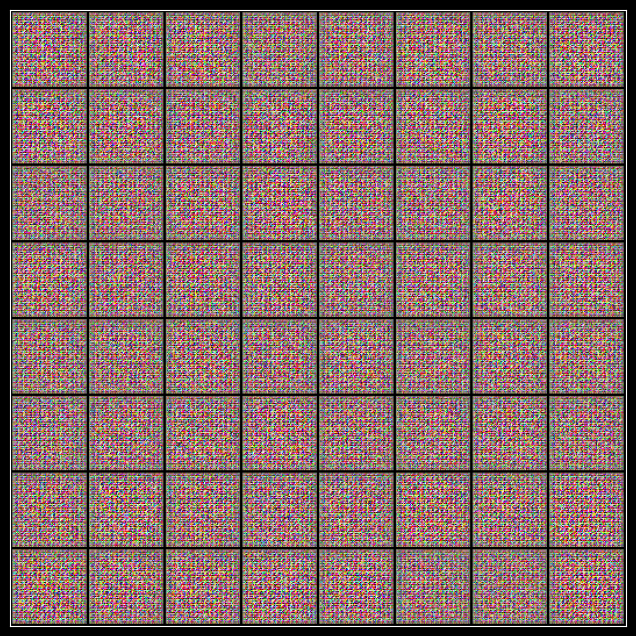

In [20]:
xb = torch.randn(
    batch_size, latent_size, 1, 1
)  # 배치 크기와 잠재 크기를 가진 랜덤 텐서 생성
fake_images = generator(xb)  # 생성자를 사용하여 가짜 이미지 생성
print(fake_images.shape)  # 생성된 가짜 이미지의 형태 출력
show_images(fake_images)  # 생성된 가짜 이미지를 보여주는 함수 호출

`to_device` 함수는 주어진 `generator` 객체를 특정 `device`에 할당하는 역할을 합니다. 이는 딥러닝 모델을 GPU와 같은 특정 하드웨어에 배치하기 위해 사용됩니다. 이 과정은 모델의 연산 속도를 향상시키기 위해 필수적입니다.


In [21]:
generator = to_device(generator, device)  # generator를 device에 할당합니다.

`os.makedirs` 함수는 지정된 경로에 디렉토리(폴더)를 재귀적으로 생성합니다. `exist_ok=True` 매개변수는 해당 디렉토리가 이미 존재하는 경우 오류를 발생시키지 않고 무시하도록 합니다. 이 예제에서는 `'generated'`라는 이름의 디렉토리를 생성하되, 이미 존재하는 경우에는 추가적인 동작 없이 프로그램을 계속 진행합니다.


In [22]:
sample_dir = "generated"
# 'generated' 디렉토리를 생성합니다. 이미 존재한다면 무시합니다.
os.makedirs(sample_dir, exist_ok=True)

이 함수는 PyTorch의 `torch.randn`을 사용하여 주어진 장치(`device`)에서 특정 차원(`64, latent_size, 1, 1`)을 가진 정규 분포 난수 텐서를 생성합니다. 여기서 `latent_size`는 텐서의 두 번째 차원을 정의하며, 이는 일반적으로 생성 모델에서 잠재 벡터의 크기를 의미합니다. 이러한 잠재 벡터는 생성적 적대 신경망(GANs) 또는 다른 생성 모델에서 중요한 역할을 합니다.


In [23]:
# 장치에 64xlatent_sizex1x1 크기의 정규 분포 난수 텐서를 생성합니다.
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

이 함수는 생성된 이미지 샘플을 저장하고 선택적으로 보여주는 기능을 수행합니다. `save_samples` 함수는 인덱스(`index`), 잠재 텐서(`latent_tensors`), 그리고 이미지를 보여줄지 여부를 결정하는 `show` 매개변수를 받습니다. 생성된 이미지(`fake_images`)는 `generator` 함수를 통해 잠재 텐서로부터 생성됩니다. 이후, 생성된 이미지는 정규화를 해제하는 `denorm` 함수를 거쳐 `save_image` 함수를 사용하여 지정된 디렉토리(`sample_dir`)에 저장됩니다. 파일 이름은 인덱스를 포함하여 포맷팅됩니다. `show` 매개변수가 `True`일 경우, matplotlib를 사용하여 생성된 이미지를 그리드 형태로 보여줍니다. 이 과정에서 x축과 y축의 눈금은 제거됩니다.


In [24]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("저장 중", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

### 네트워크 훈련하기

단계별로 생각해 봅시다.


이 함수는 생성적 적대 신경망(GAN)의 훈련 과정을 구현합니다. `fit` 함수는 모델, 손실 함수, 에폭 수, 학습률, 그리고 시작 인덱스를 매개변수로 받습니다. 훈련 과정에서는 두 가지 주요 단계가 있습니다: 판별자(discriminator)와 생성자(generator)의 훈련입니다. 판별자는 진짜 이미지와 생성된 가짜 이미지를 구분하도록 학습되며, 생성자는 판별자를 속이는 이미지를 생성하도록 학습됩니다. 각 에폭마다, 손실(loss)과 점수(score)가 계산되어 기록되며, 마지막 에폭에서는 생성된 이미지가 저장됩니다. 이 과정은 GAN 모델의 성능을 개선하는 데 중요한 역할을 합니다.


In [25]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # 손실과 점수 초기화
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # 최적화 함수 생성
    optimizer = {
        "discriminator": torch.optim.Adam(
            model["discriminator"].parameters(), lr=lr, betas=(0.5, 0.999)
        ),
        "generator": torch.optim.Adam(
            model["generator"].parameters(), lr=lr, betas=(0.5, 0.999)
        ),
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # 판별자 훈련
            optimizer["discriminator"].zero_grad()

            # 진짜 이미지를 판별자에 통과시킴
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # 가짜 이미지 생성
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # 가짜 이미지를 판별자에 통과시킴
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # 판별자 가중치 업데이트
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            # 생성자 훈련
            optimizer["generator"].zero_grad()

            # 가짜 이미지 생성
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # 판별자를 속이려고 시도
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # 생성자 가중치 업데이트
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # 손실과 점수 기록
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # 손실과 점수 로깅 (마지막 배치)
        print(
            "Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch + 1,
                epochs,
                losses_g[-1],
                losses_d[-1],
                real_scores[-1],
                fake_scores[-1],
            )
        )

        # 생성된 이미지 저장
        if epoch == epochs - 1:
            save_samples(epoch + start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

본 코드는 GAN(Generative Adversarial Networks) 모델을 설정하는 과정을 담고 있다. 여기서 `discriminator`와 `generator`는 각각 판별자와 생성자를 의미하며, 이들을 특정 디바이스(`device`)에 할당한다. 손실 함수(`criterion`)로는 이진 교차 엔트로피 손실(`nn.BCELoss()`)을 사용하며, 이는 두 부분 모두에 적용된다. 학습률(`lr`)은 0.0002로 설정되어 있고, 총 학습 에폭(`epochs`)은 55로 지정되어 있다.


In [26]:
model = {"discriminator": discriminator.to(
    device), "generator": generator.to(device)}

criterion = {"discriminator": nn.BCELoss(), "generator": nn.BCELoss()}
lr = 0.0002
epochs = 55

이 함수는 주어진 `model`을 사용하여 학습을 수행하며, `criterion`을 손실 함수로, `epochs`를 학습 에폭 수로, 그리고 `lr`을 학습률로 사용합니다. 학습이 완료된 후, 학습 과정에서의 기록(`history`)을 반환합니다. 이 기록에는 에폭별 손실 값 등 학습 과정에서의 중요한 정보가 포함될 수 있습니다.


In [27]:
history = fit(
    model, criterion, epochs, lr
)  # 모델을 학습시키고, 학습 과정의 기록을 반환합니다.

  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [1/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [2/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [3/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [4/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [5/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [6/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [7/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [8/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [9/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [10/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [11/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [12/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [13/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [14/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [15/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [16/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [17/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [18/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [19/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [20/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [21/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [22/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [23/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [24/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [25/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [26/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [27/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [28/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [29/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [30/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [31/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [32/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [33/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [34/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [35/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [36/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [37/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [38/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [39/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [40/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [41/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [42/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [43/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [44/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [45/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [46/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [47/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [48/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [49/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [50/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [51/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [52/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [53/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [54/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/169 [00:00<?, ?it/s]

Epoch [55/55], loss_g: 100.0000, loss_d: 100.0000, real_score: 0.0000, fake_score: 0.0000
저장 중 generated-images-0055.png


### 손실 시각화


이 함수는 `history` 변수에서 GAN(Generative Adversarial Networks) 학습 과정 중 발생한 손실(loss)과 점수(score)를 추출합니다. `losses_g`는 생성자(generator)의 손실, `losses_d`는 판별자(discriminator)의 손실을 나타냅니다. `real_scores`는 실제 데이터에 대한 판별자의 점수, `fake_scores`는 생성된 가짜 데이터에 대한 판별자의 점수를 의미합니다.


In [28]:
losses_g, losses_d, real_scores, fake_scores = history

In [29]:
generated_img = cv2.imread(f"./generated/generated-images-00{epochs}.png")
# epochs 변수에 따라 지정된 경로에서 이미지를 읽어옵니다.
generated_img = generated_img[:, :, [2, 1, 0]]
# 이미지의 색상 채널 순서를 BGR에서 RGB로 변경합니다.

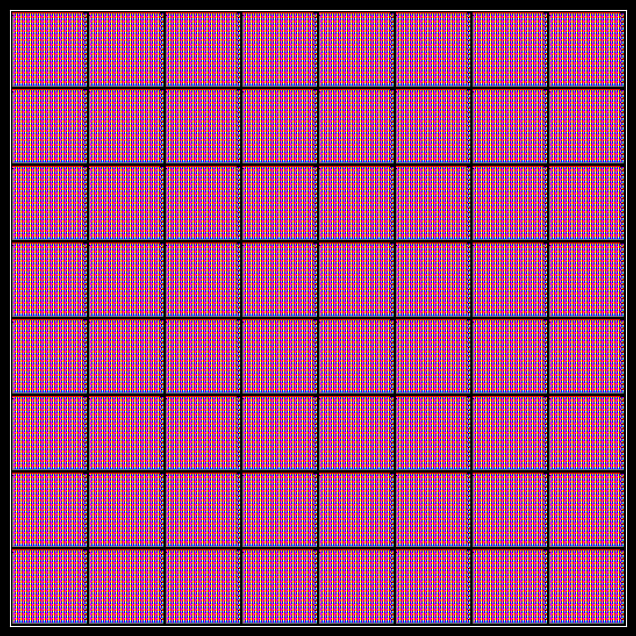

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(generated_img)

Text(0.5, 1.0, 'Losses')

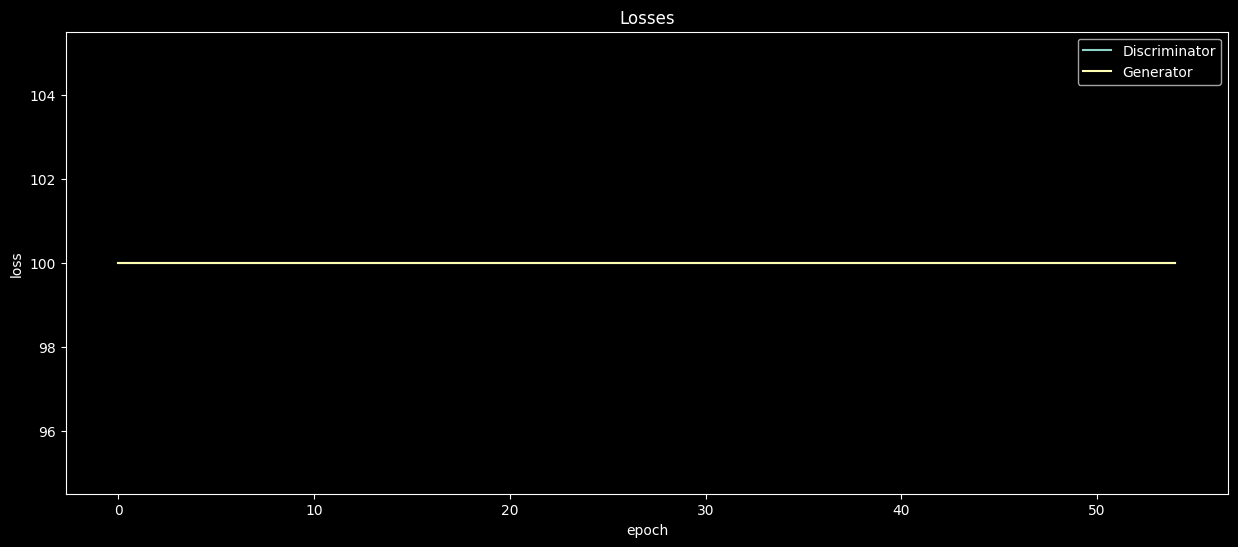

In [31]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, "-")
plt.plot(losses_g, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses")

Text(0.5, 1.0, 'Scores')

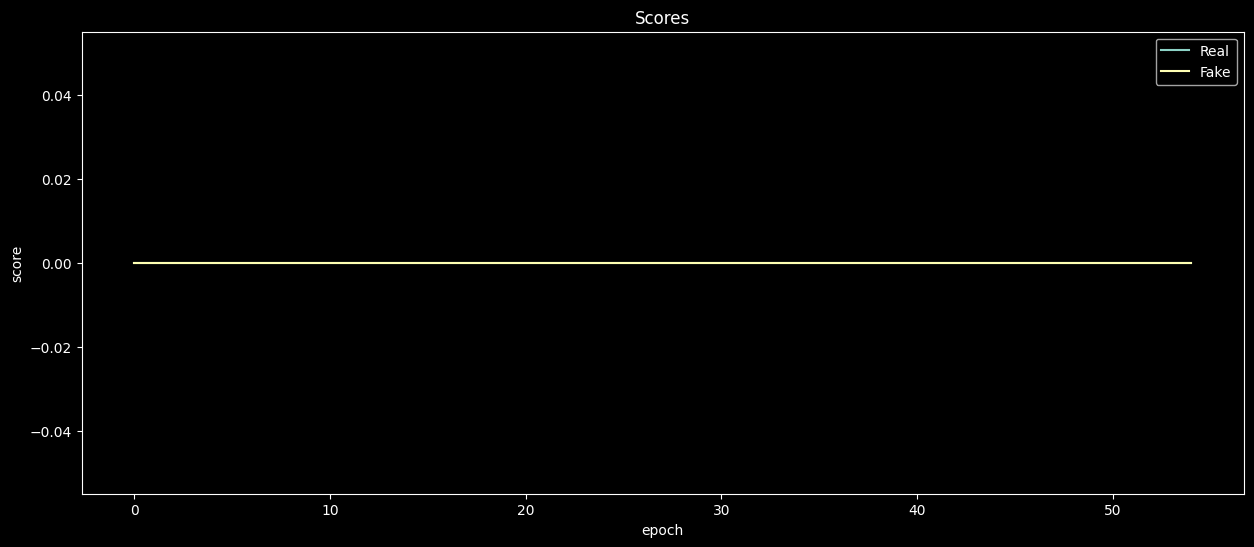

In [32]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real", "Fake"])
plt.title("Scores")